# Week 2 Lab: So where do all those reference genomes come from anyway? (Sequence assembly)

## Part 2
**Due: Monday 4/15/19 11:59PM**

**Partner: ** (optional. You must both turn in the assignment. You must choose a different partner each week.)

<font color="red">Today, make sure you log in with the *High memory* instances available when you log into datahub. These have 8 threads and 32GB of RAM available, which will be necessary for running Spades below.</font>

## 2. Assemble reads with minia

Now we are ready to start assembling our reads. We'll compare two programs. First, we'll use a lightweight program called `minia`, which doesn't take into account any pair information. Then, we'll use a second program called `spades` which can handle a variety of sequencing library types and compare the results.

To get started, type `minia` at the command line to see how to use it.

```
minia
```

`minia` needs a list of our files as input, so let's make a list of files to include. We'll use this opportunity to learn about some cool Jupyter "magics". Cell magics start with `%%`. The cell below uses the `%%file` magic, which writes the contents of that cell to the specified file. If necessary you can edit the file below to reflect actual paths to your trimmed fastq files if you named them something else. For assembling *contigs* with minia, we will use only the shortgrag library, which is what we used to get our kmer distributions using jellyfish on Tuesday.

In [1]:
%%file ~/week2/minia_input_files.txt
shortfrag_pair1.fastq
shortfrag_pair2.fastq

Writing /home/dshak/week2/minia_input_files.txt


Test that the above cell wrote your file correctly on the terminal:
```
cat ~/week2/minia_input_files.txt
```

By the way, you can also run bash commands inside of your notebook. Either using a the `%%bash` magic or starting a line with an exclamation point `!`. See examples below, pretty cool!

In [2]:
%%bash
# Example bash magic cell
cat ~/week2/minia_input_files.txt

shortfrag_pair1.fastq
shortfrag_pair2.fastq

In [3]:
# Example running command using "!"
! cat ~/week2/minia_input_files.txt

shortfrag_pair1.fastq
shortfrag_pair2.fastq

Now let's get back to running `minia`. 

The most important parameter is the `kmer-size`. From our jellyfish histogram of the corrected data, we know that a kmer of 18 produces a defined ‘true-reads’ peak, and we know where the valley is. For the minia command, you only want to use k-mers with abundance higher than this valley point (`-abundance-min`). Later we'll experiment with different kmer lengths.
 
Set the output prefix to `minia_assembly_18`.

**Question 1 (2 pts)**: Edit and run the `minia` command below based on your chosen kmer size. Paste your final command. How long did minia take (it outputs run time).

```
minia \
  -in ~/week2/mini_input_files.txt \
  -kmer-size 18 \
  -abundance-min valley \
  -out ~/week2/minia_assembly_18
```

minia \
  -in ~/week2/minia_input_files.txt \
  -kmer-size 18 \
  -abundance-min 45 \
  -out ~/week2/minia_assembly_18

The run time was 158.232 seconds.

Examine your (own) assembly. The most important file minia created is the `minia_assembly_18.contigs.fa` file, which is a list of each assembled contigs in fasta format. Use head to look at the first few contigs.

We'll introduce three new UNIX tools to help you examine the output data:

* `awk` is a general purpose tool for all sorts of data wrangling. Awk excels at parsing delimited data, where you have a lot of fields. The simplest form of an awk command is (all one line):
```
awk '/search_pattern/ {action to take on matches; another_action;}' [path to file]
```

For example, the following command prints out every other line of our fasta file (i.e., only the lines with sequences on them). This may be useful below.
```
cat minia_assembly_18.contigs.fa | awk 'NR%2==0 {print length}'
```
Here `NR` means "row number" (or record number) and prints out rows where row number mod 2 is 0. `length` prints the length of the line. For files with many columns, you can also do `length($i)` to print the length of column `i`.

* `sort` allows you to sort files. You can use `cat file.txt | sort -k2,2` to sort only on column 2, etc. See [the sort man page](http://man7.org/linux/man-pages/man1/sort.1.html) for more options. You may find it useful to pipe output of other tools into `sort. e.g.:
```
cat minia_assembly_18.contigs.fa | awk 'NR%2==0 {print length}' | sort -n
```

* `datamash` is a really helpful tool for cmputing simple operations on columns of data. Below is an example of how to use the command. Type `datamash --help` for more usage info.

```
cat minia_assembly_18.contigs.fa | awk '{print length}' | datamash min 1 # print min of column 1
```

**Question 2 (5 pts)**: Gather some basic statistics about the contigs. Write one-line UNIX commands to answer the following. Paste your commands in the cell below. In the cell below that, set the variables `num_contigs`, `longest_contig_length`,  `shortest_contig_length`, and `median_contig_length` to your answers.
* How many contigs are there?
* What is the longest contig length?
* What is the shortest congit length?
* What is the median contig length?

* Finding the number of contigs = 13566<br>
cat minia_assembly_18.contigs.fa | grep '>' | tail<br>
cat minia_assembly_18.contigs.fa | grep '>' | wc -l


* Finding the longest contig length = 5374<br>
cat minia_assembly_18.contigs.fa | grep '>' | awk '{print$2}' | cut -d: -f3 | sort -n | tail -n 1<br>


* Finding the shortest contig length =  18<br>
cat minia_assembly_18.contigs.fa | grep '>' | awk '{print$2}' | cut -d: -f3 | sort -n | head -n 1<br>

* Finding the median contig length = 176<br>
cat minia_assembly_18.contigs.fa | grep '>' | awk '{print$2}' | cut -d: -f3 | datamash median 1



In [5]:
# Set the variables to your answers from the above commands
num_contigs = 13566
longest_contig_length = 5374
shortest_contig_length = 18
median_contig_length = 176


In [6]:
"""Check num_contigs"""

'Check num_contigs'

In [8]:
"""Check contig lengths"""

'Check contig lengths'

## 3. Scaffolding the minia contigs

These short contigs are certainly not a complete genome. Even if they cover all of the sequence in our genome (they might not; there could be missing regions), we do not know the correct order to put them in to reconstitute the real genome sequence.

Fortunately, we can use a second set of DNA sequencing data to help us figure out the correct way to join the contigs together. Our contigs were initially made by stitching together 100 bp reads from DNA fragments that were ~215 bp long. Our second DNA library (jumping) consists of paired 146 bp reads from DNA fragments that were up to several kb long. You will map these short jumps to your set of contigs.

If the forward member of a pair binds to one contig, and its reverse partner binds to a different contig, we know that those positions must be several kb apart in the actual genome. By combining all of the mapping data from these pairs, scaffolding software can figure out the optimal, correct way to link the contigs together.

You will use the program `SSPACE` for scaffolding. First, it will use the bowtie aligner (within the program) to map the shortjump reads to your minia contigs. Then, it will use those mapping results to connect the contigs into bigger scaffolds. 

`SSPACE` requires a library file, telling the program the names of our `shortfrag` files and some other information about them. Use You will have to look at the SSPACE user manual to figure out exactly what each column means https://github.com/nsoranzo/sspace_basic/blob/master/F132-01%20SSPACE_Basic_User_Manual_v2.0.pdf.

Example library file:
```
Lib1 reads_1.fastq reads_2.fastq insertsize insertsizeerror orientation
```

You will have to specify the the insert size, the tolerable error for the insert size, and the orientation. We will want to add both of our libraries (`shortfrag` and `jumping`). Be sure to use the trimmed reads. For `jumping` only use the mate pairs. Note, `nxtrim` by default outputs all reads in FR orientation, even if they were RF to begin with. 

Before running, you'll have to "unzip" the the mate pair fastq files. Use the `gunzip` command to do this.

**Question 3 (3 pts):** Fill in your `SSPACE` library file in the cell below. Write your library file to `sspace_library.txt` in your `~/week2` folder. (You may use a `%%file` magic below to write directly to the file. Put the `shortfrag` library first.)

Note 1: the insert size for the `shortfrag` library is given in Lab 1 (215 +/- 10bp). For the `jumping` library let's assume 1000 +/- 500bp. (This is not quite right, but a priori for this library we don't have a good distribution).

Note 2: Pay attention to how `insertsizeerror` is defined in the manual. It is a number between 0 and 1, and *not* a standard deviation.

In [9]:
%%file ~/week2/sspace_library.txt
Lib1 shortfrag_pair1.fastq shortfrag_pair2.fastq 215 0.0465 FR
Lib2 jumping_nxtrim_R1.mp.fastq jumping_nxtrim_R2.mp.fastq 1000 0.5 FR

Writing /home/dshak/week2/sspace_library.txt


Once you’ve made the library file, run `SSPACE` with the command below, which you will have to edit according to your exiting file names and your output name preference. A description of what each flag is doing follows the command.

```shell
SSPACE_Basic_v2.0.pl -l sspace_library.txt -s minia_assembly_18.contigs.fa -z 100 -v 1 -p 1 -b sspace_scaffold
```

* `-l` specifies the library file
* `-s` specifies the list of contigs that minia produced
* `-z` sets the minimum required size for contigs (anything shorter than this will be discarded)
* `-p` tells the program to make a dot file, which can be used to visualize the scaffold
* `-v` sets verbose output
* `-b` sets the base file name for the output directory and the files in it.

(Note this may take a while. You can try making it `SSPACE` use multiple threads but only go up to 6. You might want to open a new terminal and work on the next part).

**Question 4 (2 pts):** After the command runs, open the summary file it created. Record how many scaffolds there are “After scaffolding”, the max scaffold size, and the N50. (This is also where you can get those numbers for your original contig file, under “Inserted contig file”). How did the quality of scaffolding change after the `jumping` library was added?

After scaffolding there are 586 total scaffolds (after the second library is added). The max scaffold size increases to 74635 after adding both libraries. The N50 is 17715. The quality of the scaffolding increases after the jumping library is added. We can see this by the increase in the N50 score and the size of the average scaffold size, they both increase 

## 4. Assemble reads with Spades

Now we'll use a second assembler, Spades, to assemble our reads. But first, we'll run kmer-based error correction on the reads which will greatly reduce the memory required to run Spades.

For error correction, we'll use the tool `bfc`. Type the command to see its usage. Then use it to correct the two trimmed fastqs for our `shortfrag` and `jumping` library. Below is an example command:

```
bfc -s 5m trimmed.fq > corrected.fq
```

Note, `-s 5m` tells `bfc` we expect our genome size to be around 5 Megabases, based on our results from part 1!

**Question 5 (2 pts):** Paste your command from running `bfc` below. Note this may take a while, so you might want to work on the "Additional questions" section below while you're waiting. You can also figure out how to make `bfc` use multiple threads at once to speed it up. But don't use more than 8 threads.

bfc -s 4.4m shortfrag_pair1.fastq -t 8 > shortfrag_pair1_corrected.fastq

bfc -s 4.4m shortfrag_pair2.fastq -t 8 > shortfrag_pair2_corrected.fastq

bfc -s 4.4m jumping_nxtrim_R1.mp.fastq -t 8 > jumping_nxtrim_R1_corrected.mp.fastq

bfc -s 4.4m jumping_nxtrim_R2.mp.fastq -t 8 > jumping_nxtrim_R2_corrected.mp.fastq


Hopefully, running error correction helped get rid of some of the low abundance kmers in our data.

**Question 6 (3 pts)** Run `jellyfish` on one fastq file from each library file before and after trimming. Paste your commands below (1 pt). After completing the plots in question 7, describe here the difference in the distribution before and after error correction. (2 pts). 

jellyfish count -m 18 -C -s 100M -o jf_shortfrag1.jf shortfrag_pair1.fastq<br>
jellyfish histo jf_shortfrag1.jf > shortfrag1.histo

jellyfish count -m 18 -C -s 100M -o jf_shortfrag_pair1_corrected.jf shortfrag_pair1_corrected.fastq<br>
jellyfish histo jf_shortfrag_pair1_corrected.jf > jf_shortfrag_pair1_corrected.histo

jellyfish count -m 18 -C -s 100M -o jf_jumping_nxtrim_R1.mp.jf jumping_nxtrim_R1.mp.fastq<br>
jellyfish histo jf_jumping_nxtrim_R1.mp.jf > jf_jumping_nxtrim_R1.mp.histo

jellyfish count -m 18 -C -s 100M -o jf_jumping_nxtrim_R1_corrected.mp.jf  jumping_nxtrim_R1_corrected.mp.fastq<br>
jellyfish histo jf_jumping_nxtrim_R1_corrected.mp.jf > jf_jumping_nxtrim_R1_corrected.mp.histo

**Question 7 (3 pts)**. Plot the resulting kmer count histograms below for each library before and after correction. (4 total plots). You will probably want to copy your function `PlotKmerHistogram` from Part 1, and may need to play with the x-axis range for the different libraries. You may also need to add `%pylab inline` to the top of the cell.

In [31]:
%pylab inline
import os
import matplotlib.pyplot as plt

def PlotKmerHistogram(histofile, max_xval = 350, max_yval = 52500):
    """
    Takes in the path to a histogram file from jellyfish and 
    plots the kmer count distribution
    """
    max_xval = max_xval
    max_yval = max_yval
    kmer_counts = {} # Dictionary of count -> number of kmers
    # Read the histofile
    # Use its contents to update kmer_counts
    # You also will need to set max_xval and max_yval to something appropriate
    text_file = open(histofile, "r")
    data = text_file.read().splitlines()
    for i in range(len(data)):
        kmer_counts[int(data[i].split()[0])] = int(data[i].split()[1])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(kmer_counts.keys(), kmer_counts.values(),width=1)
    ax.set_xlabel("Count")
    ax.set_ylabel("Number of kmers")
    if max_xval is not None: ax.set_xlim(left=0, right=max_xval)
    if max_yval is not None: ax.set_ylim(bottom=0, top=max_yval)

Populating the interactive namespace from numpy and matplotlib


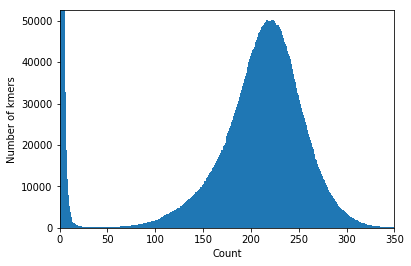

In [12]:
PlotKmerHistogram(os.path.join(os.environ["HOME"],"week2","shortfrag1.histo")) # may need to edit the path to your file

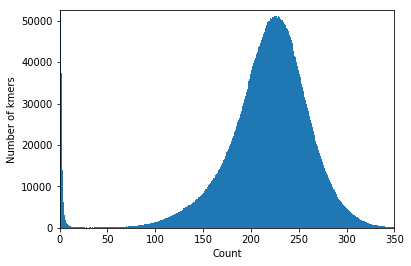

In [13]:
PlotKmerHistogram(os.path.join(os.environ["HOME"],"week2","jf_shortfrag_pair1_corrected.histo")) # may need to edit the path to your file

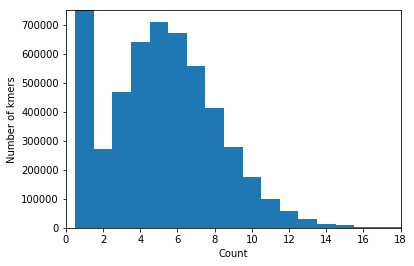

In [65]:
PlotKmerHistogram(os.path.join(os.environ["HOME"],"week2","jf_jumping_nxtrim_R1.mp.histo"), max_xval=18, max_yval = 750000) # may need to edit the path to your file

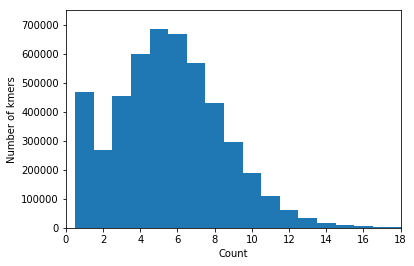

In [66]:
PlotKmerHistogram(os.path.join(os.environ["HOME"],"week2","jf_jumping_nxtrim_R1_corrected.mp.histo"), max_xval=18, max_yval = 750000) # may need to edit the path to your file

Now, we're ready to run Spades. Type `spades.py` to see options. Using the usage message as a guide, write a spades command that:

* Takes in the `jumping` mate pair kmer-corrected reads (library)
* Takes in the `shortfrag` paired end reads (library)
* Outputs the results to a folder `~/week2/ECMG1-spades`.
* Uses at most 25G of memory
* Uses 7 threads
* Only runs the assembler (since we already ran kmer based error correction).

**Question 8 (3 pts):** Run spades using the options specified above, and paste your command below.

#### Makes sense to use the corrected libraries for both

spades.py -o ~/week2/ECMG1-spades -m 25 -t 7 --only-assembler --mp1-fr --mp1-1 jumping_nxtrim_R1_corrected.mp.fastq --mp1-2 jumping_nxtrim_R2_corrected.mp.fastq --pe1-1 shortfrag_pair1_corrected.fastq --pe1-2 shortfrag_pair2_corrected.fastq

#### Not sure if need corrected shortfrag paired end read library

spades.py -o ~/week2/ECMG1-spades -m 25 -t 7 --only-assembler --mp1-fr --mp1-1 jumping_nxtrim_R1_corrected.mp.fastq --mp1-2 jumping_nxtrim_R2_corrected.mp.fastq --pe1-1 shortfrag_pair1.fastq --pe1-2 shortfrag_pair2.fastq

**Question 9 (4 pts):** Similar to how you did for `minia`, gather some basic statistics about the **contigs** created by Spades. Find the contigs that `spades` wrote to the folder `~/week2/ECMG1-spades`. Write UNIX commands to answer the following:

* How many contigs are there?
* What is the longest contig length?
* What is the shortest congit length?
* What is the median contig length?

Paste your commands in the cell below. In the cell below that, set the variables `num_contigs_spades`, `longest_contig_length_spades`,  `shortest_contig_length_spades`, and `median_contig_length_spades` to your answers.

**IMPORTANT**: Take a look at the fasta file. Hint it looks different than the `minia` contigs! This file is in "multi-line" fastq format vs. "single-line" fastq format so some of the commands you wrote to look at minia contigs might not work. As suggested in class, one of the most important skills of a bioinformatician is googling :). Google this issue and see if you can find a UNIX command (or a tool) that will convert your fastq file to a format you want. Or, write your own command. Or, make your commands for getting the stats above deal with multi-line format. 

===== Assembling finished. Used k-mer sizes: 21, 33, 55

 * Assembled contigs are in /home/dshak/week2/ECMG1-spades/contigs.fasta
 * Assembled scaffolds are in /home/dshak/week2/ECMG1-spades/scaffolds.fasta
 * Assembly graph is in /home/dshak/week2/ECMG1-spades/assembly_graph.fastg
 * Assembly graph in GFA format is in /home/dshak/week2/ECMG1-spades/assembly_graph_with_scaffolds.gfa
 * Paths in the assembly graph corresponding to the contigs are in /home/dshak/week2/ECMG1-spades/contigs.paths
 * Paths in the assembly graph corresponding to the scaffolds are in /home/dshak/week2/ECMG1-spades/scaffolds.paths

cat contigs.fasta | grep '>' | wc -l

cat contigs.fasta | grep '>' | cut -d_ -f4 | sort -n | tail -n 1

cat contigs.fasta | grep '>' | cut -d_ -f4 | sort -n | head -n 1

cat contigs.fasta | grep '>' | cut -d_ -f4 | datamash median 1

In [50]:
# Set the variables to your answers from the above commands
num_contigs_spades = 167
longest_contig_length_spades = 521291
shortest_contig_length_spades = 56
median_contig_length_spades = 232


In [51]:
"""Check num contigs and contig lengths"""

'Check num contigs and contig lengths'

**Question 10 (2 pts):** Repeat the same evaluation for **scaffolds** generated by spades. Again, paste your commands below and set the appropriate python variables to your answers.

cat scaffolds.fasta | grep '>' | wc -l

cat scaffolds.fasta | grep '>' | cut -d_ -f4 | sort -n | tail -n 1

cat scaffolds.fasta | grep '>' | cut -d_ -f4 | sort -n | head -n 1

cat scaffolds.fasta | grep '>' | cut -d_ -f4 | datamash median 1

In [52]:
# Set the variables to your answers from the above commands
num_scaffold_spades = 128
longest_scaffold_length_spades = 4583975
shortest_scaffold_length_spades = 56
median_scaffold_length_spades = 146.5


In [53]:
"""Check num contigs and contig lengths"""

'Check num contigs and contig lengths'

## 5. Compare assembly methods

Now, we will summarize all of our stats from our two methods (`minia`+`sspace` vs. `spades`).

Let's construct a table (which you can do in [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) syntax right here in a Jupyter cell). Below is an example blank table so you can see the syntax.

**Question 11 (7 pts)**: Summarize for each the two methods:
* For contigs: number, min, max and median length, and N50 (see below)
* For scaffolds: number, min, max and median length, and N50

Paste any additional commands you used to get the output.

Discuss (3-5 sentences total) how the two methods compare in terms of:
* assembly quality
* ease of use
* compute requirements

Example table:

| Metric | Method 1 | Method 2 |
|----|-----|-----|
| Contig - # | | 
| Contig - min | |
| Contig - median | | 
| Contig - max | | 
| ... | |

**Notes**
* For computing N50: you may either (1) google for a method to compute N50 from a fasta file or (2) Write your own. Include any commands you used. If you write a script, paste the contens of the script below.
* Try to format code and tables nicely using markdown tricks! This is good preparation for writing full-length lab reports and the final project soon!

In [82]:
import numpy as np
vals = !cat ../week2/ECMG1-spades/scaffolds.fasta | grep '>' | cut -d_ -f4
vals = np.array(list(map(int, vals)))
running_coverage = np.cumsum(vals)/np.sum(vals)
for i,coverage in enumerate(running_coverage):
    if coverage >= 0.5:
        break
        
N50 = vals[i]
print(N50)

4583975


In [103]:
contig_vals = !cat ../week2/ECMG1-spades/contigs.fasta | grep '>' | cut -d_ -f4
contig_vals = np.array(list(map(int, contig_vals)))

running_coverage = np.cumsum(contig_vals)/np.sum(contig_vals)
for i,coverage in enumerate(running_coverage):
    if coverage >= 0.5:
        break
        
N50 = contig_vals[i]
print(N50)

171820


In [105]:
#method1 N50
contig_vals = !cat ../week2/minia_assembly_18.contigs.fa | grep '>' | awk '{print$2}' | cut -d: -f3 | sort -n
contig_vals = np.array(list(map(int, contig_vals)))
contig_vals = contig_vals[::-1]

running_coverage = np.cumsum(contig_vals)/np.sum(contig_vals)
for i,coverage in enumerate(running_coverage):
    if coverage >= 0.5:
        break
        
N50 = contig_vals[i]
print(N50)

768


Method 1 median scaffold length: 

cat sspace_scaffold.final.scaffolds.fasta | grep '>' | cut -de -f2 | datamash median 1


| Metric | Method 1 | Method 2 |
|----|-----|-----|
| Contig - # | 13566| 167
| Contig - min | 18| 56
| Contig - median | 176| 232
| Contig - max | 5374| 521291
| Contig N50 | 768 | 171820
| Scaffold - # | 586 | 128
| Scaffold - min | 100 | 56
| Scaffold - median | 3212.5 | 146.5
| Scaffold - max | 74635 | 4583975
| Scaffold N50 | 17715 | 4583975

## 6. Evaluate assembly outputs with QUAST

Even though we were unable to link every stretch of DNA together into a finished genome, we were still able to produce lots of sequences, which could be used for gene finding, comparison to related bacteria, or as a guide for designing additional sequencing projects to fill in the gaps and link the remaining contigs.

Since we are using raw data from a genome that is actually already solved, we can align our contigs to that reference to evaluate our de novo assembly performance. Remember, if we were trying to solve the genome of a new or unknown organism, we wouldn’t be able to do this, but we could try using a close relative.

The NCBI id of the E. coli strain used here is NC_000913.3. The reference genome fasta file and gene annotations (GFF file) are available here: https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.3. This reference (K-12 substr. MG1655) is actually already available on QUAST, so we won't need to download it. Download the final scaffold files (after `sspace` and after `spades` for the two methods) by navigating to your `week2` folder in Jupyter lab, right clicking the files, and selecting "Download".

Go to QUAST: http://quast.bioinf.spbau.ru/

First, make sure that you will get an email report. On the right hand side, type in your email and click ‘get personal page’. Close the QUAST tab, then wait for the email to arrive. Click on the “Personal Page” link, and perform your analysis there in order to get the results emailed.

Use quast to align your scaffolds to the actual reference sequence of the bacterial strain used to generate the original data.

* Use “Add Files” to upload both of your assemblies for comparison.
* Check the "scaffolds", “find genes” boxes, and the “Prokaryotic” button.
* Under genome, choose the strain of our genome.
* Type in a title for this analysis under caption, then click evaluate. 

You may also use the "Icarus" browser to explore the differences between assemblies.

**Question 12 (1 pt)**: Explain why there are two results, and what the ‘broken’ result is (you will have to use the QUAST manual. But don't just copy and paste. Use your own words to describe the difference).

The broken result is done when evaluating the continuous scaffolds. If there are large sections of "n" (unkown values for a position) the program splits up the scaffold at these points and tries to realign these sections to the known positions in the reference. This is done to give a comparison of how the scaffolding did compared to the actual alignment of the contigs to the referecne.

**Question 13 (1 pt)**:  Which metrics perform better in the Spades vs. Minia+Sspace assemblies? You don't need to provide an exhaustive list of each metric. Rather, provide an overall summary of the differences.

It seems that in general the Minia+Sspace assembly has smaller contigs/scaffolds. There are less continuous runs of sequences. The N50 is much larger in the Spades method. This creates one really large scaffold that contains most of the data. Some of these differecne could have been cause by not creating contigs off the jumping library.

**Question 14 (1 pt)**: Does the number of genes (operons) predicted by QUAST for your assembly match the actual number of genes in the assembled reference?

The number of genes predicted by QUAST is very similar to the actual number of genes in teh assembled reference. The assembled reference has listed, Number of protein genes: 4240, Number of RNA genes: 179. Our results predict 4252 + 18 part	4244 + 26 part	3711 + 447 part	3218 + 926 part. The Spades method is a lot better at generating the gene sections. This can be due to the longer read/scaffolds of continuous reads.

## 7. Additional questions

**Question 13 (3 pts)**: We chose a specific value for $k$ (18) for our `minia` assembly. What do you think would happen if we chose a larger value of $k$? What are the tradeoffs of larger vs. shorter kmer sizes?

The larger kmer size can help with areas of the genome that are hard to decipher. These regions can be ones that are highly repetative for example. The larger kmer size can also contribute to longer contigs with fewer connections where as the smaller kmer size will have more contigs with more connections. The larger the kmer size the more coverage is needed however.

**Question 14 (3 pts)**: What could you do to improve your assembly, and properly connect the final scaffolds, without relying on a reference sequence?

To improve the assembly there are numerous things that can be done. First different kmer sizes can be utilized to cross validate the results. More data will usually help as well. This can be different types of reads, more reads, and different length reads. Using all these methods and then comparing all the different values for a consensus should help to make the assembly more robust and accurate.